In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Mounted at /gdrive/
MyDrive  Shareddrives


In [ ]:
import os
! pip install -q kaggle

if not os.path.exists('/content/sudoku.csv'):
  if not os.path.exists('~/.kaggle'):
    ! mkdir ~/.kaggle
  ! cp /gdrive/MyDrive/kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d bryanpark/sudoku
  ! unzip -a sudoku.zip

if not os.path.exists('/content/pt_util.py'):
 ! cp /gdrive/MyDrive/pt_util.py /content

In [ ]:
!ls

sample_data  sudoku.csv  sudoku.zip


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
import pandas as pd
import pt_util

In [ ]:
quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
data = np.zeros((1000000, 2, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
        data[i, 0, j] = q
        data[i, 1, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))
data = data.reshape((-1, 2, 9, 9))

In [ ]:
quizzes = quizzes.reshape((-1, 1, 9, 9))
solutions = solutions.reshape((-1, 1, 9, 9))
data = data.reshape((-1, 2, 1, 9, 9))

In [ ]:
print(quizzes.shape)
print(solutions.shape)
print(data.shape)
train_quizzes = quizzes[:800000,:,:]
test_quizzes = quizzes[800000:,:,:]
train_solutions = solutions[:800000,:,:]
test_solutions = solutions[800000:,:,:]
train_data = data[:200000,:,:,:]
test_data = data[200000:210000,:,:,:]
print(train_quizzes.shape)
print(test_solutions.shape)

(1000000, 1, 9, 9)
(1000000, 1, 9, 9)
(1000000, 2, 1, 9, 9)
(800000, 1, 9, 9)
(200000, 1, 9, 9)


In [ ]:
print(train_data[0,0,:,:])
print(train_data[0,1,:,:])

[[[0 0 4 3 0 0 2 0 9]
  [0 0 5 0 0 9 0 0 1]
  [0 7 0 0 6 0 0 4 3]
  [0 0 6 0 0 2 0 8 7]
  [1 9 0 0 0 7 4 0 0]
  [0 5 0 0 8 3 0 0 0]
  [6 0 0 0 0 0 1 0 5]
  [0 0 3 5 0 8 6 9 0]
  [0 4 2 9 1 0 3 0 0]]]
[[[8 6 4 3 7 1 2 5 9]
  [3 2 5 8 4 9 7 6 1]
  [9 7 1 2 6 5 8 4 3]
  [4 3 6 1 9 2 5 8 7]
  [1 9 8 6 5 7 4 3 2]
  [2 5 7 4 8 3 9 1 6]
  [6 8 9 7 3 4 1 2 5]
  [7 1 3 5 2 8 6 9 4]
  [5 4 2 9 1 6 3 7 8]]]


In [ ]:
# Data loader
from torch.utils.data import Dataset, DataLoader
class sudokuDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data

    def __len__(self):
        return self.data.shape[0]
      
    def __getitem__(self, idx):
        feat = self.data[idx, 0, :, :]
        label = self.data[idx, 1, :, :]
        processed = np.zeros((9, 9, 9))
        for i in range(9):
          for j in range(9):
            processed[label[0, i, j] - 1, i, j] = 1 
        if self.transform:
            data = self.transform(data)
        
        return (torch.from_numpy(feat).float(), torch.from_numpy(processed).float())

class sudokuDatasetChannel(Dataset):
    def __init__(self, data, transform=None):
      self.transform = transform
      self.data = data

    def __len__(self):
        return self.data.shape[0]
      
    def __getitem__(self, idx):
        feat = self.data[idx, 0, :, :]
        label = self.data[idx, 1, :, :]
        processed_label = np.zeros((9, 9, 9))
        processed_feat = np.zeros((9, 9, 9))

        for i in range(9):
          for j in range(9):
            processed_label[label[0, i, j] - 1, i, j] = 1 
            if feat[0, i, j]:
              processed_feat[feat[0, i, j] - 1, i, j] = 1
        
        return (torch.from_numpy(processed_feat).float(), torch.from_numpy(processed_label).float())

class sudokuDatasetChannelFlattenLabel(Dataset):
    def __init__(self, data, transform=None):
      self.transform = transform
      self.data = data

    def __len__(self):
        return self.data.shape[0]
      
    def __getitem__(self, idx):
        feat = self.data[idx, 0, :, :]
        label = self.data[idx, 1, :, :]
        processed_label = np.zeros((9, 9, 9))
        processed_feat = np.zeros((9, 9, 9))

        for i in range(9):
          for j in range(9):
            processed_label[label[0, i, j] - 1, i, j] = 1 
            if feat[0, i, j]:
              processed_feat[feat[0, i, j] - 1, i, j] = 1
        
        return (torch.from_numpy(processed_feat).float(), torch.flatten(torch.from_numpy(processed_label).float()))

In [ ]:
train_loader = DataLoader(sudokuDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(sudokuDataset(test_data), batch_size=1, shuffle=True)
#print(train_loader.dataset.__getitem__(0))

train_loader_channel = DataLoader(sudokuDatasetChannel(train_data), batch_size=16, shuffle=True)
test_loader_channel = DataLoader(sudokuDatasetChannel(test_data), batch_size=1, shuffle=True)
print(train_loader_channel.dataset.__getitem__(0))

train_loader_flattern = DataLoader(sudokuDatasetChannelFlattenLabel(train_data), batch_size=16, shuffle=True)
test_loader_flattern = DataLoader(sudokuDatasetChannelFlattenLabel(test_data), batch_size=1, shuffle=True)
print(train_loader_flattern.dataset.__getitem__(0))

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, inputs=9*9, hidden=512, outputs=(9*9)):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:

! mkdir checkpoints
file_path = "checkpoints"
class sudokuNet(nn.Module):
    def __init__(self):
        super(sudokuNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 9, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(9, 1, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(9*9, 9*9)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.softmax(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


class sudokuNetChannel(nn.Module):
    def __init__(self):
        super(sudokuNetChannel, self).__init__()
        self.conv1 = nn.Conv2d(9, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 9, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(9*9*9, 9*9*9)
        self.accuracy = None

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        #x = F.relu(x)
        x = x.reshape((-1, 9, 9 ,9))
        x = self.conv1(x)
        x = F.relu(x)
        #x = nn.BatchNorm2d(16)(x)
        x = self.conv2(x)
        x = F.relu(x)
        #x = nn.BatchNorm2d(32)(x)
        x = self.conv3(x)
        x = F.relu(x)
        #x = nn.BatchNorm2d(16)(x)
        x = self.conv4(x)
        #x = nn.BatchNorm2d(9)(x)
        #x = F.softmax(x, dim=1)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [ ]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

In [ ]:
model = sudokuNetChannel().to(device)
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY, momentum=0.9)
train_loss = []
train_loss += train(model, train_loader_channel, lr=0.1)
train_loss += train(model, train_loader_channel, lr=0.05)
train_loss += train(model, train_loader_channel, lr=0.05)
train_loss += train(model, train_loader_channel, lr=0.01, momentum=0.5)
train_loss += train(model, train_loader_channel, lr=0.01, momentum=0.5)

[1,   100] loss: 2.19731
[1,   200] loss: 2.19717
[1,   300] loss: 2.19712
[1,   400] loss: 2.19706
[1,   500] loss: 2.19694
[1,   600] loss: 2.19681
[1,   700] loss: 2.19641
[1,   800] loss: 2.19573
[1,   900] loss: 2.19334
[1,  1000] loss: 2.17611
[1,  1100] loss: 2.10503
[1,  1200] loss: 2.00066
[1,  1300] loss: 1.87394
[1,  1400] loss: 1.75473
[1,  1500] loss: 1.65122
[1,  1600] loss: 1.55054
[1,  1700] loss: 1.45688
[1,  1800] loss: 1.37783
[1,  1900] loss: 1.30997
[1,  2000] loss: 1.25355
[1,  2100] loss: 1.20501
[1,  2200] loss: 1.16579
[1,  2300] loss: 1.12104
[1,  2400] loss: 1.09185
[1,  2500] loss: 1.05921
[1,  2600] loss: 1.03631
[1,  2700] loss: 1.00539
[1,  2800] loss: 0.98328
[1,  2900] loss: 0.96238
[1,  3000] loss: 0.94375
[1,  3100] loss: 0.92705
[1,  3200] loss: 0.90808
[1,  3300] loss: 0.89626
[1,  3400] loss: 0.87563
[1,  3500] loss: 0.85966
[1,  3600] loss: 0.85121
[1,  3700] loss: 0.83527
[1,  3800] loss: 0.82089
[1,  3900] loss: 0.81058
[1,  4000] loss: 0.79487


In [ ]:
test_losses = test(model, test_loader_channel)


Test set: Average loss: 0.0000, Accuracy: 75710.0/10000 (16%)



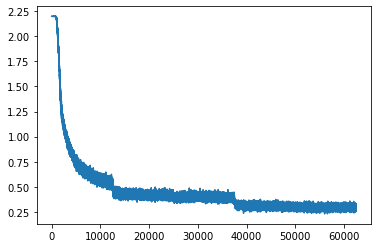

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
#plt.plot(test_losses)

In [ ]:
import time
import torch.optim as optim

def train(net, dataloader, optimizer, epoch=1, verbose=True):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()

  sum_loss = 0.0
  for i, batch in enumerate(dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = batch[0].to(device), batch[1].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize 
    outputs = net(inputs)
    '''
    y = torch.zeros([outputs.shape[0], 1, 9, 9])
    for k in range(outputs.shape[0]):
      for i in range(9):
        for j in range(9):
          y[k, 0, i, j] = torch.argmax(outputs[k, :, i, j])+1
          print(y[k, 0, i, j])
    '''
    print("INPUT")
    #print(inputs)
    #print("LABEL")
    #print(labels)
    #print("OUTPUT")
    #print(outputs)
    # break
    
    loss = criterion(outputs, torch.flatten(labels, 1))
    print(loss)
    break
    loss.backward()
    optimizer.step()

    # print statistics
    losses.append(loss.item())
    sum_loss += loss.item()
    if i % 100 == 99:    # print every 100 mini-batches
      if verbose:
        print('[%d, %5d] loss: %.3f' %
            (epoch, i + 1, sum_loss / 100))
      sum_loss = 0.0
    
  return losses

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    blank_cnt = 0

    with torch.no_grad():
      for batch_idx, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)
        output = model(data)
        
        blank_mask = torch.zeros([output.shape[0], 1, 9, 9]).floats()
        for k in range(output.shape[0]):
          for i in range(9):
            for j in range(9):
              is_blank = True
              for n in range(9):
                if data[k, n, i, j] != 0:
                  is_blank = False
                  break;
              if is_blank:
                blank_mask[k, 0, i, k] = 1.0
                blank_cnt += 1
        
        x = torch.zeros([output.shape[0], 1, 9, 9])
        for k in range(output.shape[0]):
          for i in range(9):
            for j in range(9):
              x[k, 0, i, j] = torch.argmax(output[k, :, i, j])+1
        
        y = torch.zeros([label.shape[0], 1, 9, 9])
        for k in range(label.shape[0]):
          for i in range(9):
            for j in range(9):
              y[k, 0, i, j] = torch.argmax(label[k, :, i, j])+1

        correct_mask = x.eq(y.view_as(x))

        num_correct = (correct_mask * blank_mask).sum().item()

        correct += num_correct
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset) /81
    test_accuracy = 100. * correct / blank_cnt

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 1
TEST_BATCH_SIZE = 10
EPOCHS = 1
LEARNING_RATE = 0.01
MOMENTUM = 0.5
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0
GAMMA = 0.9
DATA_PATH = "checkpoints/sudokuNetChannel"

EXPERIMENT_VERSION = "0.1" # increment this to start a new experiment

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())


"""
Simple sudokuNet
Parameters:
BATCH_SIZE = 32
TEST_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.5
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0
GAMMA = 0.9
DATA_PATH = "checkpoints/sudokuNet"
"""
# model = sudokuNet().to(device)
# train_loader = DataLoader(sudokuDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# test_loader = DataLoader(sudokuDataset(test_data), batch_size=TEST_BATCH_SIZE, shuffle=True)

"""
9-Channel sudokuNet
"""
model = sudokuNetChannel().to(device)
train_loader = DataLoader(sudokuDatasetChannel(train_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(sudokuDatasetChannel(test_data), batch_size=TEST_BATCH_SIZE, shuffle=True)

start_epoch = 1
if os.listdir(DATA_PATH):
 start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
 print(f"loaded from {DATA_PATH}, starting from epoch {start_epoch}")

lr = LEARNING_RATE * (np.power(GAMMA, start_epoch))

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, GAMMA)

losses = []
accuracies = []

for epoch in range(start_epoch, EPOCHS+1):
  print(f"CURRENT EPOCH: {epoch}")
  train_loss = train(model, train_loader, optimizer, epoch-1)
  _, accuracy = test(model, test_loader)
  losses.extend(train_loss)
  # accuracies.append(accuracy)
  model.save_best_model(accuracy, DATA_PATH+f"/epoch{epoch}.pt")



Using device cpu
num cpus: 2
CURRENT EPOCH: 1
INPUT


RuntimeError: ignored